# `Материалы кафедры ММП факультета ВМК МГУ. Введение в Эффективные Системы Глубокого Обучение.`

# `Семинар 01. Введение в CUDA`

### `Материалы составил Феоктистов Дмитрий (@trandelik)`

#### `Москва, Осенний семестр 2025`

О чём можно узнать из этого ноутбука:

* Базовые принципы вычислений на GPU
* Синтаксис Numba CUDA

Документация [Numba CUDA Guide](https://numba.readthedocs.io/en/stable/cuda/index.html)

При составлении семинара авторы сильно вдохновлялись [GPU puzzles](https://github.com/srush/GPU-Puzzles)

**Важно**: авторы настоятельно рекомендуют выполнять данный ноутбук в Google Colab и не гарантируют поддержку других сред. Также мы приведем версии CUDA, драйверов, python и библиотек ниже.

### `Setup`

In [ ]:
!pip install numba-cuda==0.4.0


from numba import config
config.CUDA_ENABLE_PYNVJITLINK = 1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 453.8/453.8 kB 8.2 MB/s eta 0:00:00
  Attempting uninstall: numba-cuda
    Found existing installation: numba-cuda 0.11.0
    Uninstalling numba-cuda-0.11.0:
      Successfully uninstalled numba-cuda-0.11.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 25.6.0 requires numba-cuda<0.12.0a0,>=0.11.0, but you have numba-cuda 0.4.0 which is incompatible.


In [ ]:
import numpy as np
import numba
from numba import cuda
import math
from time import time

In [ ]:
!nvidia-smi

Wed Sep  3 11:00:57 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


In [ ]:
import sys

print("Python version:", sys.version)
print("Numba version:", numba.__version__)
print("Numpy version:", np.__version__)

Python version: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
Numba version: 0.60.0
Numpy version: 2.0.2


In [ ]:
device = cuda.get_current_device()
print(f"GPU: {device.name.decode('UTF-8')}")
print(f"Compute Capability: {device.compute_capability}")
print(f"Max Threads Per Block: {device.MAX_THREADS_PER_BLOCK}")

GPU: Tesla T4
Compute Capability: (7, 5)
Max Threads Per Block: 1024


### `Базовый параллелизм`

Основная идея вычислений на GPU — это массовый параллелизм. Вместо одного мощного ядра (как в CPU) у нас есть тысячи простых ядер, которые могут выполнять одну и ту же операцию над разными данными одновременно. Эта модель называется **SIMD (Single Instruction, Multiple Data)**.

В CUDA мы организуем потоки (threads) в иерархическую структуру:
- **Grid**: Сетка, содержащая все потоки, которые будут выполнять нашу задачу.
- **Block**: Грид состоит из блоков. Потоки внутри одного блока могут синхронизироваться и использовать быструю общую память (shared memory).
- **Thread**: Самая маленькая единица вычислений.

Функция, которая выполняется на GPU, называется **ядром (kernel)**. В Numba мы создаем ядро, декорируя обычную функцию Python с помощью `@cuda.jit`.

При запуске ядра мы указываем конфигурацию запуска: `[blocks_per_grid, THREADS_PER_BLOCK]`. Это определяет, сколько блоков будет в гриде и сколько потоков в каждом блоке.

Каждый поток имеет уникальные координаты, которые позволяют ему понять, какую часть данных он должен обработать:
- `cuda.threadIdx.x, .y, .z`: Индекс потока внутри блока.
- `cuda.blockIdx.x, .y, .z`: Индекс блока внутри грида.
- `cuda.blockDim.x, .y, .z`: Размерность блока (количество потоков в блоке).

Чтобы получить **глобальный уникальный индекс** потока в 1D-гриде, используется формула:
`idx = cuda.grid(1)` что эквивалентно `cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x`.

Реализуем простейший кернел, вычисляющий функцию `ReLU(x) = max(0, x)` для вектора. Будем считать, что размер вектора маленький, то есть количество элементов в векторе не превосходит количества тредов.

In [ ]:
@cuda.jit
def relu_no_bounds_check_kernel(x):
    idx = cuda.threadIdx.x
    if x[idx] < 0:
        x[idx] = 0

In [ ]:
THREADS_PER_BLOCK = 128
blocks_per_grid = 1

data = np.random.uniform(-1, 1, THREADS_PER_BLOCK).astype(np.float32)
data_device = cuda.to_device(data)

relu_no_bounds_check_kernel[blocks_per_grid, THREADS_PER_BLOCK](data_device)
cuda.synchronize()

result = data_device.copy_to_host()
print(data[:10].round(2))
print(result[:10].round(2))
assert np.all(result >= 0)

/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:605: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


[ 0.26  0.88 -0.5   0.35 -0.03  0.05 -0.91  0.    0.37 -0.34]
[0.26 0.88 0.   0.35 0.   0.05 0.   0.   0.37 0.  ]


Однако в текущей реализации мы допускаем страшную ошибку - мы не проверяем, что читаем действительно существующие данные, что может приводить к Undefined Behaviour на массивах, размеры которых не совпадают с количеством тредов.

In [ ]:
data = np.random.uniform(-1, 1, 10).astype(np.float32)
data_device = cuda.to_device(data)
relu_no_bounds_check_kernel[blocks_per_grid, THREADS_PER_BLOCK](data_device)
result = data_device.copy_to_host()
print(data[:10].round(2))
print(result[:10].round(2))
assert np.all(result >= 0)

[-0.29 -0.2  -0.73 -0.65  0.91  0.47  0.38  0.93  0.79  0.56]
[0.   0.   0.   0.   0.91 0.47 0.38 0.93 0.79 0.56]


И мы даже не узнаем о том, что в нашем кернеле есть проблема. Чтобы детектировать проблемы с памятью, у CUDA есть специальный `compute sanitizer`.

In [ ]:
%%writefile relu.py

from numba import config
config.CUDA_ENABLE_PYNVJITLINK = 1
import numpy as np
from numba import cuda


@cuda.jit
def relu_no_bounds_check_kernel(x):
    idx = cuda.threadIdx.x
    if x[idx] < 0:
        x[idx] = 0


THREADS_PER_BLOCK = 128
blocks_per_grid = 1
data = np.random.uniform(-1, 1, 10).astype(np.float32)
data_device = cuda.to_device(data)
relu_no_bounds_check_kernel[blocks_per_grid, THREADS_PER_BLOCK](data_device)
cuda.synchronize()
result = data_device.copy_to_host()
print(data[:10].round(2))
print(result[:10].round(2))
assert np.all(result >= 0)

Overwriting relu.py


In [ ]:
# !compute-sanitizer python relu.py

Исправим эту ошибку

In [ ]:
@cuda.jit
def relu_with_bounds_check_kernel(x):
    idx = cuda.threadIdx.x
    if idx < x.shape[0]:
        if x[idx] < 0:
            x[idx] = 0

In [ ]:
data = np.random.uniform(-1, 1, 10).astype(np.float32)
data_device = cuda.to_device(data)
relu_with_bounds_check_kernel[blocks_per_grid, THREADS_PER_BLOCK](data_device)
cuda.synchronize()
result = data_device.copy_to_host()
print(data[:10].round(2))
print(result[:10].round(2))
assert np.all(result >= 0)

[ 0.29 -0.55  0.98 -0.47 -0.92 -0.92  0.76  0.98  0.39  0.87]
[0.29 0.   0.98 0.   0.   0.   0.76 0.98 0.39 0.87]


/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:605: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


In [ ]:
%%writefile relu.py

from numba import config
config.CUDA_ENABLE_PYNVJITLINK = 1
import numpy as np
from numba import cuda


@cuda.jit
def relu_with_bounds_check_kernel(x):
    idx = cuda.threadIdx.x
    if idx < x.shape[0]:
        if x[idx] < 0:
            x[idx] = 0

THREADS_PER_BLOCK = 128
blocks_per_grid = 1
data = np.random.uniform(-1, 1, 10).astype(np.float32)
data_device = cuda.to_device(data)
relu_with_bounds_check_kernel[blocks_per_grid, THREADS_PER_BLOCK](data_device)
cuda.synchronize()
result = data_device.copy_to_host()
print(data[:10].round(2))
print(result[:10].round(2))
assert np.all(result >= 0)

Overwriting relu.py


In [ ]:
!compute-sanitizer python relu.py

========= COMPUTE-SANITIZER
/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:605: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
[-0.73 -0.31  0.87 -0.54 -0.15 -0.13  0.22 -0.34  0.41  0.63]
[0.   0.   0.87 0.   0.   0.   0.22 0.   0.41 0.63]
========= ERROR SUMMARY: 0 errors


Теперь научимся работать с векторами произвольного размера

In [ ]:
@cuda.jit
def relu_long_vector_kernel(x):
    idx = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
    if idx < x.shape[0]:
        if x[idx] < 0:
            x[idx] = 0

In [ ]:
N = 1_000_000
data = np.random.uniform(-1, 1, N).astype(np.float32)


blocks_per_grid = (N + (THREADS_PER_BLOCK - 1)) // THREADS_PER_BLOCK

print(f"Размер данных: {N}")
print(f"Потоков в блоке: {THREADS_PER_BLOCK}")
print(f"Количество блоков: {blocks_per_grid}")
print(f"Всего потоков будет запущено: {THREADS_PER_BLOCK * blocks_per_grid}")

data_device = cuda.to_device(data)
relu_long_vector_kernel[blocks_per_grid, THREADS_PER_BLOCK](data_device)
cuda.synchronize()
result_long = data_device.copy_to_host()

assert np.all(result_long >= 0)

Размер данных: 1000000
Потоков в блоке: 128
Количество блоков: 7813
Всего потоков будет запущено: 1000064


И напишем функцию-обертку для нашего кернела. Примерно так будет выглядеть итоговая реализация ReLU для векторов.

In [ ]:
THREADS_PER_BLOCK = 128

@cuda.jit
def relu_long_vector_kernel(x):
    idx = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
    if idx < x.shape[0]:
        if x[idx] < 0:
            x[idx] = 0


def relu(x):
    N = x.shape[0]
    blocks_per_grid = (N + (THREADS_PER_BLOCK - 1)) // THREADS_PER_BLOCK
    x_device = cuda.to_device(x.copy())
    relu_long_vector_kernel[blocks_per_grid, THREADS_PER_BLOCK](x_device)
    cuda.synchronize()
    result = x_device.copy_to_host()
    return result

In [ ]:
N = 1_000_000
data = np.random.uniform(-1, 1, N).astype(np.float32)
result = relu(data)

assert np.all(result >= 0)

### `2D Grid`

Задачи не всегда одномерны. Для обработки матриц, изображений и других 2D/3D структур удобно использовать многомерные гриды и блоки. Конфигурация запуска в этом случае задается кортежами, например: `blocks_per_grid = (16, 16)`, `THREADS_PER_BLOCK = (16, 16)`.

Для получения глобальных 2D-координат используется `x, y = cuda.grid(2)`.

Это сильно упрощает код, так как нам не нужно вручную вычислять 2D-индексы `(row, col)` из одного глобального 1D-индекса. Каждый поток теперь "думает" в терминах 2D-координат, что идеально подходит для обработки изображений.

Реализуем кернел, переводящий цветное RGB изображение в черно-белое. Для этого будем использовать стандартную формулу для перевода:

$Gray = 0.299 \cdot R + 0.587 \cdot G + 0.114 \cdot b$

In [ ]:
@cuda.jit
def rgb_to_grayscale_kernel(rgb_img, gray_img):
    x = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
    y = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y

    height, width = gray_img.shape

    if x < width and y < height:
        r = rgb_img[y, x, 0]
        g = rgb_img[y, x, 1]
        b = rgb_img[y, x, 2]
        gray_value = 0.299 * r + 0.587 * g + 0.114 * b
        gray_img[y, x] = gray_value

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
image_path = 'image.jpeg'
pil_image = Image.open(image_path)
host_rgb_image = np.array(pil_image)

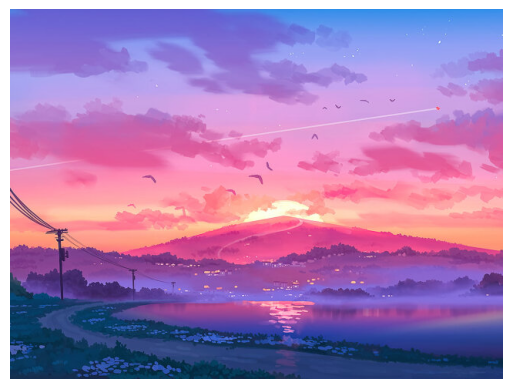

In [ ]:
plt.imshow(host_rgb_image)
plt.axis('off')
plt.show()

In [ ]:
height, width = host_rgb_image.shape[0], host_rgb_image.shape[1]
host_gray_image = np.empty((height, width), dtype=np.float32)

device_rgb_image = cuda.to_device(host_rgb_image)
device_gray_image = cuda.to_device(host_gray_image)

THREADS_PER_BLOCK_2D = (16, 16)
blocks_per_grid_x = math.ceil(width / THREADS_PER_BLOCK_2D[0])
blocks_per_grid_y = math.ceil(height / THREADS_PER_BLOCK_2D[1])
blocks_per_grid_2d = (blocks_per_grid_x, blocks_per_grid_y)

rgb_to_grayscale_kernel[blocks_per_grid_2d, THREADS_PER_BLOCK_2D](device_rgb_image, device_gray_image)
cuda.synchronize()
result_gray_image = device_gray_image.copy_to_host()

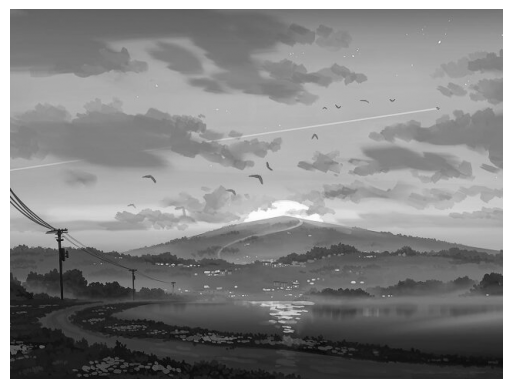

In [ ]:
result_gray_image_norm = (result_gray_image / 255.0).astype(np.float32)

plt.imshow(result_gray_image_norm, cmap='gray')
plt.axis('off')
plt.show()

### `Синхронизация`

Когда несколько потоков пытаются одновременно читать и изменять одни и те же данные, возникает **состояние гонки (race condition)**. Результат такой операции становится непредсказуемым. Для борьбы с этим существуют механизмы синхронизации.

1.  **Атомарные операции (`atomic operations`)**: Это операции (например, `add`, `sub`, `max`), которые выполняются как единое, неделимое действие. Если два потока одновременно вызовут `cuda.atomic.add()` для одной ячейки памяти, GPU гарантирует, что они выполнятся последовательно, а не одновременно, предотвращая потерю данных. Это надежно, но может снижать производительность, так как вносит элемент последовательного выполнения.

2.  **Синхронизация внутри блока (`cuda.syncthreads()`)**: Это барьер синхронизации. Поток, дошедший до этой инструкции, останавливается и ждет, пока ВСЕ остальные потоки **в том же блоке** не дойдут до этого же места. Это позволяет, например, сначала всем потокам блока загрузить данные в быструю общую память, а уже потом, после синхронизации, начать их обрабатывать, будучи уверенными, что все данные на месте. **Важно:** `syncthreads()` не синхронизирует потоки между разными блоками.

Реализуем простой кернел, который вычисляет, сколько раз число 10 встретилось во входном массиве

In [ ]:
@cuda.jit
def count_tens_race_condition_kernel(data, result_counter):
    idx = cuda.grid(1)
    if idx < data.shape[0]:
        if data[idx] == 10:
            result_counter[0] += 1

In [ ]:
N = 1024 * 1024
THREADS_PER_BLOCK = 256
blocks_per_grid = (N + (THREADS_PER_BLOCK - 1)) // THREADS_PER_BLOCK

host_data = np.full(N, 10, dtype=np.int32)
host_data[N//2:] = 0
np.random.shuffle(host_data)
correct_answer = N // 2

host_counter = np.zeros(1, dtype=np.int32)

device_data = cuda.to_device(host_data)
device_counter = cuda.to_device(host_counter)

count_tens_race_condition_kernel[blocks_per_grid, THREADS_PER_BLOCK](device_data, device_counter)
cuda.synchronize()

result = device_counter.copy_to_host()[0]

print(f"Правильный ответ: {correct_answer}")
print(f"Полученный результат: {result}")

Правильный ответ: 524288
Полученный результат: 110


In [ ]:
@cuda.jit
def count_tens_atomic_kernel(data, result_counter):
    idx = cuda.grid(1)
    if idx < data.shape[0]:
        if data[idx] == 10:
            cuda.atomic.add(result_counter, 0, 1)

In [ ]:
host_counter = np.zeros(1, dtype=np.int32)

device_data = cuda.to_device(host_data)
device_counter = cuda.to_device(host_counter)

count_tens_atomic_kernel[blocks_per_grid, THREADS_PER_BLOCK](device_data, device_counter)
cuda.synchronize()
result = device_counter.copy_to_host()[0]

print(f"Правильный ответ: {correct_answer}")
print(f"Полученный результат: {result}")

Правильный ответ: 524288
Полученный результат: 524288


Теперь добавим в задачу модификацию. Пусть каждый блок считает количество цифр в своем участке и выведет их. Заодно посмотрим, как делать принты из кернелов

In [ ]:
@cuda.jit
def print_tens_per_block_wo_sync_kernel(data, block_counts):
    idx = cuda.grid(1)
    block_id = cuda.blockIdx.x
    block_dim = cuda.blockDim.x
    if idx < data.shape[0]:
        if data[idx] == 10:
            cuda.atomic.add(block_counts, block_id, 1)
    if cuda.threadIdx.x == 0:
        print("Block", block_id, "10 count:", block_counts[block_id])

In [ ]:
from wurlitzer import sys_pipes

In [ ]:
N = 1024
THREADS_PER_BLOCK = 256
blocks_per_grid = (N + (THREADS_PER_BLOCK - 1)) // THREADS_PER_BLOCK

host_data = np.full(N, 10, dtype=np.int32)
host_data[N//2:] = 0
np.random.shuffle(host_data)

host_counter = np.zeros(blocks_per_grid, dtype=np.int32)

device_data = cuda.to_device(host_data)
device_counter = cuda.to_device(host_counter)
with sys_pipes():
    print_tens_per_block_wo_sync_kernel[blocks_per_grid, THREADS_PER_BLOCK](device_data, device_counter)
    cuda.synchronize()

/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:605: NumbaPerformanceWarning: Grid size 4 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Block 1 10 count: 133
Block 0 10 count: 117
Block 2 10 count: 132
Block 3 10 count: 130


In [ ]:
@cuda.jit
def print_tens_per_block_kernel(data, block_counts):
    idx = cuda.grid(1)
    block_id = cuda.blockIdx.x
    block_dim = cuda.blockDim.x
    if idx < data.shape[0]:
        if data[idx] == 10:
            cuda.atomic.add(block_counts, block_id, 1)
    cuda.syncthreads()
    if cuda.threadIdx.x == 0:
        print("Block", block_id, "10 count:", block_counts[block_id])

In [ ]:
N = 1024
THREADS_PER_BLOCK = 256
blocks_per_grid = (N + (THREADS_PER_BLOCK - 1)) // THREADS_PER_BLOCK

host_data = np.full(N, 10, dtype=np.int32)
host_data[N//2:] = 0
np.random.shuffle(host_data)

host_counter = np.zeros(blocks_per_grid, dtype=np.int32)

device_data = cuda.to_device(host_data)
device_counter = cuda.to_device(host_counter)
with sys_pipes():
    print_tens_per_block_wo_sync_kernel[blocks_per_grid, THREADS_PER_BLOCK](device_data, device_counter)
    cuda.synchronize()

Block 1 10 count: 126
Block 0 10 count: 124
Block 2 10 count: 140
Block 3 10 count: 122


### `Shared memory`

**Shared Memory (общая память)** — это небольшой объём очень быстрой on-chip памяти (~48-96 КБ), доступной всем потокам *одного блока*. Время доступа к ней сравнимо со временем доступа к регистрам и на порядки быстрее, чем к глобальной памяти GPU (DRAM).

**Основной паттерн использования:**
1.  Каждый поток блока загружает один или несколько элементов из медленной глобальной памяти в быструю общую память.
2.  **Синхронизация!** `cuda.syncthreads()` вызывается, чтобы убедиться, что все потоки завершили загрузку данных.
3.  Потоки выполняют вычисления, многократно обращаясь к данным уже в быстрой общей памяти.
4.  Каждый поток записывает свой финальный результат обратно в глобальную память.

Этот подход резко сокращает количество обращений к медленной глобальной памяти, что является ключом к высокой производительности во многих задачах (свертки, умножение матриц, редукции).

В Numba общая память создается с помощью `cuda.shared.array(shape, dtype)`.

Реализуем следующую функцию pooling-а:

`out[i] = a[i - 2] + a[i - 1] + a[i]`

In [ ]:
@cuda.jit
def pooling_shared_mem_kernel(a, out):
    shared_mem = cuda.shared.array(shape=128 + 2, dtype=numba.float32)

    glob_idx = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
    loc_idx = cuda.threadIdx.x

    sm_idx = loc_idx + 2

    if glob_idx < a.shape[0]:
        shared_mem[sm_idx] = a[glob_idx]
    else:
        shared_mem[sm_idx] = 0

    if loc_idx < 2:
        halo_glob_idx = cuda.blockIdx.x * cuda.blockDim.x + loc_idx - 2

        if halo_glob_idx >= 0:
            shared_mem[loc_idx] = a[halo_glob_idx]
        else:
            shared_mem[loc_idx] = 0

    cuda.syncthreads()
    if glob_idx > 1 and glob_idx < a.shape[0]:
        result = shared_mem[sm_idx - 2] + shared_mem[sm_idx - 1] + shared_mem[sm_idx]
        out[glob_idx] = result

In [ ]:
N = 10_000
a = np.arange(N, dtype=np.float32)
out = np.zeros_like(a)
out_cpu = np.zeros_like(a)
for i in range(2, N):
    out_cpu[i] = a[i-2] + a[i-1] + a[i]

d_a = cuda.to_device(a)
d_out = cuda.to_device(out)
d_temp = cuda.to_device(np.zeros_like(a))

THREADS_PER_BLOCK = 128
blocks_per_grid = (N + THREADS_PER_BLOCK - 1) // THREADS_PER_BLOCK
pooling_shared_mem_kernel[blocks_per_grid, THREADS_PER_BLOCK](d_a, d_out)
cuda.synchronize()


result_gpu = d_out.copy_to_host()
assert np.allclose(out_cpu[2:], result_gpu[2:])

/usr/local/lib/python3.12/dist-packages/numba_cuda/numba/cuda/dispatcher.py:605: NumbaPerformanceWarning: Grid size 79 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


### `Parallel reduction`

**Редукция** – это операция, сводящая массив данных к одному значению (например, поиск суммы, максимума, минимума). В параллельном исполнении редукция выполняется по схеме, напоминающей турнир или дерево.

1. Массив разбивается на части (например, по блокам).
2. В каждом блоке потоки находят "локальный" максимум, используя общую память.
3. Потоки попарно сравнивают/суммируют значения, сокращая количество активных данных вдвое на каждой итерации, пока в общей памяти не останется одно значение — максимум для всего блока.
4. Этот локальный максимум записывается в глобальный массив результатов (по одному значению на блок).
5. Запускается второе, маленькое ядро (или на CPU), чтобы найти финальный максимум среди результатов от всех блоков.

Ключевой момент для производительности — **паттерн доступа к памяти**. Когда соседние потоки (например, с `threadIdx.x=0,1,2,3...`) обращаются к соседним ячейкам памяти (`addr, addr+1, addr+2, ...`), такой доступ называется **коалесцированным (coalesced)**, и он очень быстрый, так как на самом деле инструкция загрузки загружает не одно число, а сразу несколько. Если же соседние потоки обращаются к далеким друг от друга ячейкам, доступ становится **шагающим (strided)** и замедляется.

Рассмотрим задачу нахождения максимума в массиве и реализуем две варсии parallel reduction

In [ ]:
@cuda.jit
def reduce_max_bad_pattern_kernel(data, out):
    shared_memory = cuda.shared.array(shape=128, dtype=numba.float32)

    idx = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
    loc_idx = cuda.threadIdx.x
    if idx < data.shape[0]:
        shared_memory[loc_idx] = data[idx]
    else:
        shared_memory[loc_idx] = numba.float32(-1e10)
    cuda.syncthreads()

    stride = 1
    while stride < cuda.blockDim.x:
        if loc_idx % (2 * stride) == 0:
            shared_memory[loc_idx] = max(shared_memory[loc_idx], shared_memory[loc_idx + stride])
        stride *= 2
        cuda.syncthreads()

    if loc_idx == 0:
        out[cuda.blockIdx.x] = shared_memory[0]

In [ ]:
N = 1024 * 1024
data_reduce = np.random.rand(N).astype(np.float32)

THREADS_PER_BLOCK = 128
blocks_per_grid = (N + THREADS_PER_BLOCK - 1) // THREADS_PER_BLOCK

device_data = cuda.to_device(data_reduce)
device_out = cuda.device_array(blocks_per_grid, dtype=np.float32)

start = time()
reduce_max_bad_pattern_kernel[blocks_per_grid, THREADS_PER_BLOCK](device_data, device_out)
cuda.synchronize()
t_bad = time() - start

block_maxes = device_out.copy_to_host()
final_max_bad = block_maxes.max()

print(f"Время: {t_bad:.5f} c")
print(f"Максимум (CPU): {data_reduce.max()}")
print(f"Максимум (GPU): {final_max_bad}")

Время: 0.10382 c
Максимум (CPU): 0.9999990463256836
Максимум (GPU): 0.9999990463256836


In [ ]:
@cuda.jit
def reduce_max_good_pattern_kernel(data, out):
    shared_memory = cuda.shared.array(shape=128, dtype=numba.float32)

    idx = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
    loc_idx = cuda.threadIdx.x
    if idx < data.shape[0]:
        shared_memory[loc_idx] = data[idx]
    else:
        shared_memory[loc_idx] = numba.float32(-1e10)
    cuda.syncthreads()

    stride = cuda.blockDim.x // 2
    while stride > 0:
        if loc_idx < stride:
            shared_memory[loc_idx] = max(shared_memory[loc_idx], shared_memory[loc_idx + stride])
        cuda.syncthreads()
        stride //= 2

    if loc_idx == 0:
        out[cuda.blockIdx.x] = shared_memory[0]

In [ ]:
device_data = cuda.to_device(data_reduce)
device_out = cuda.device_array(blocks_per_grid, dtype=np.float32)

start = time()
reduce_max_good_pattern_kernel[blocks_per_grid, THREADS_PER_BLOCK](device_data, device_out)
cuda.synchronize()
t_good = time() - start

block_maxes = device_out.copy_to_host()
final_max_good = block_maxes.max()

print(f"Время: {t_good:.5f} c")
print(f"Максимум (CPU): {data_reduce.max()}")
print(f"Максимум (GPU): {final_max_good}")

print(f"\nУскорение за счет правильного паттерна доступа: {t_bad / t_good:.2f}x")

Время: 0.08274 c
Максимум (CPU): 0.9999990463256836
Максимум (GPU): 0.9999990463256836

Ускорение за счет правильного паттерна доступа: 1.25x


### `Tiled matmul`

[Источник](https://alvinwan.com/how-to-tile-matrix-multiplication/)

Рассмотрим стандартный способ перемножить матрицы:

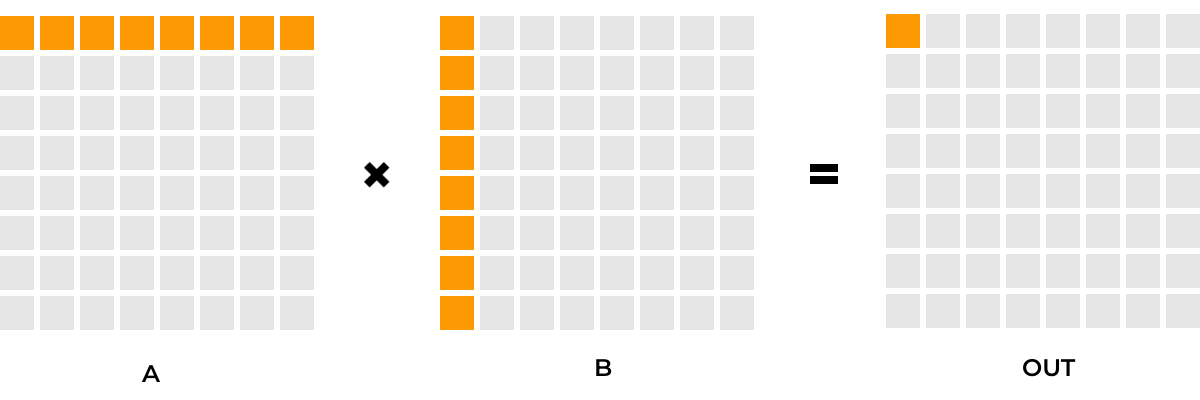

Более подробное описание этого алгоритма:

 * Выберем первую строку матрицы A (8 чтений)
 * Выберем первый столбец матрицы B (8 чтений)
 * Возьмем их скалярное произведение, чтобы получить одно значение итоговой матрицы
 * Повторим это для всех 64 выходных значений

Для каждого из 64 значений в выходной матрице нам нужно прочитать в общей сложности 16 значений: 8 значений из A и 8 значений из B. Это означает, что нам нужно прочитать 1024 значения из глобальной мамяти.

Заметим, что мы можем переиспользовать первую строку матрицы A и провести все вычсиления с ней сразу после загрузки:

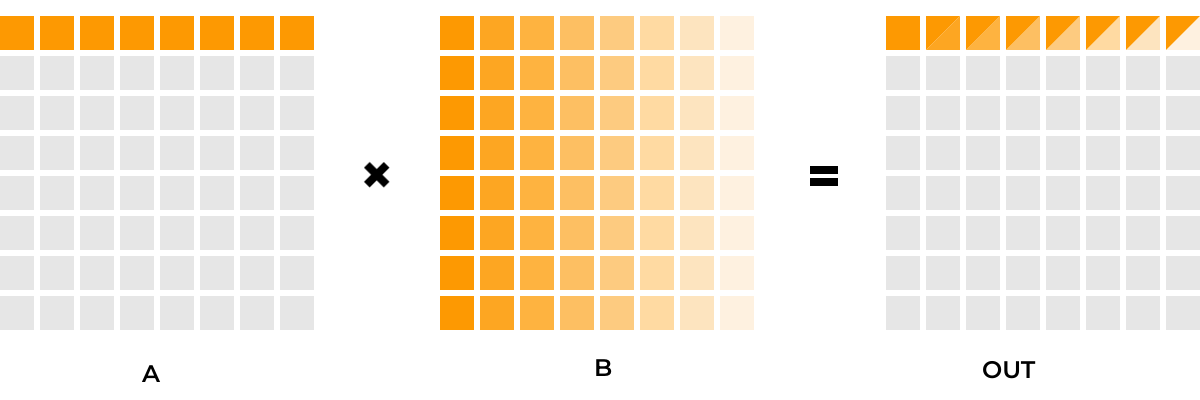

Теперь нам потребуется для каждой строки выходной матрицы считывать: одну строку матрицы A и 8 строк матрицы B. Итого 72 чтения на строку, что приводит к необходимости делать 576 чтения для получения результата. Однако, мы все еще неэффективно читаем матрицу B. Чтобы решить эту проблему, будем вычислять результат не построчно, а поблочно:

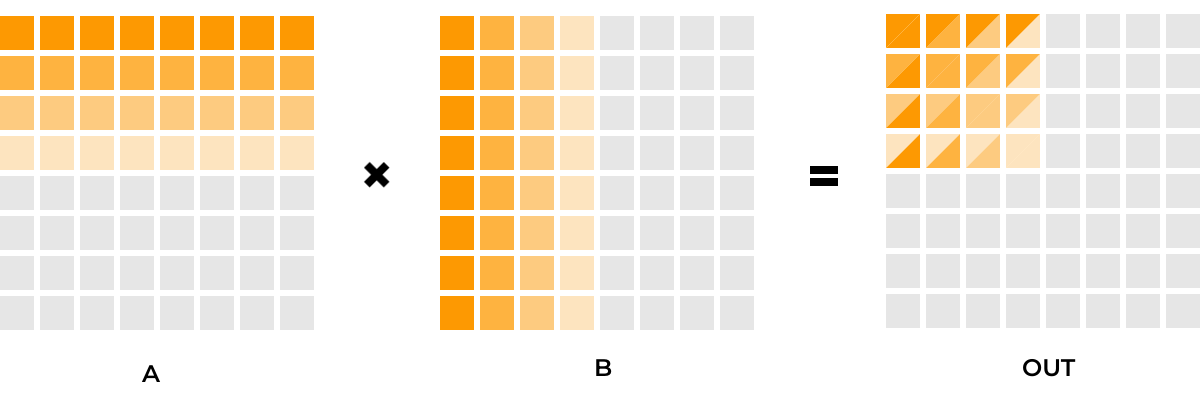

Теперь каждый блок размера 4 на 4 выходной матрицы требует чтения 4х строк матрицы A и 4x столбцов матрицы B. То есть на каждый блок уходит по 64 чтения или 256 чтений на вычисление результата. Легко можно заметить, что использование n на n блоков будет приводить к тому, что нам требует в n раз чтений. Круто? Круто! Как переложить этот алгоритм на GPU? Идея простая: каждый тред (r, c) вычисляет соответствующий элемент выходной матрицы. Для этого треды с первым индексом r вместе выгружают r строку матрицы A, а треды со вторым индексом c вместе выгружают c столбец матрицы B (как это сделать мы описывать не будем). После того, как все треды это прочитали, заметим, что в силу того, что треды с близкими (r, c) расположены в одном блоке, то в shared memory лежат нужные столбцы матрицы A и B. После чего легко посчитать нужное скалярное проивзедение и записать в выход.

Однако, тут в дело вступает жестокая реальность. Например, мы хотим перемножить матрицы размера 4096x4096, с помощью блоков размера 8x8. Чтобы посчитать один блок выходной матрицы, нам надо 8 строк по 4096 значения и 8 столбцов по 4096 значения. Итого, 131 килобайт. Однако, например, у V100 только 96 килобайт shared memory. Как с этим жить?

* Мы можем использовать блок размера 4x4. Это потребует всего 66 килобайт, но приведет к двухкратному увеличению количества чтений из глобальной памяти.

* Можем смириться с тем, что не влезаем в shared memory, и почитав в интернете, что в таком случае происходит, узнать, что мы будем читать из L2 кэша, который должен быть довольно быстрый... Но он аж в 6 раз медленнее, чем shared memory

Грустная ситуация, но к счастью есть еще один прием!

Вернемся к нашему алгоритму перемножения матриц размера 8 на 8. Если мы используем блоки 4 на 4, то нам надо читать 32 числа из A, 32 из B и иметь место под 16 чисел выходной матрицы. Итого 80 чисел. Предположим, что наша shared memory позволяет хранить только 48 чисел. Можно ли как-то адаптировать наш алгоритм под эти ограничения, не уменьшая размер блока? Да! Давайте загружать только часть строк A и часть столбцов B за раз, такие блоки называются `tile`:

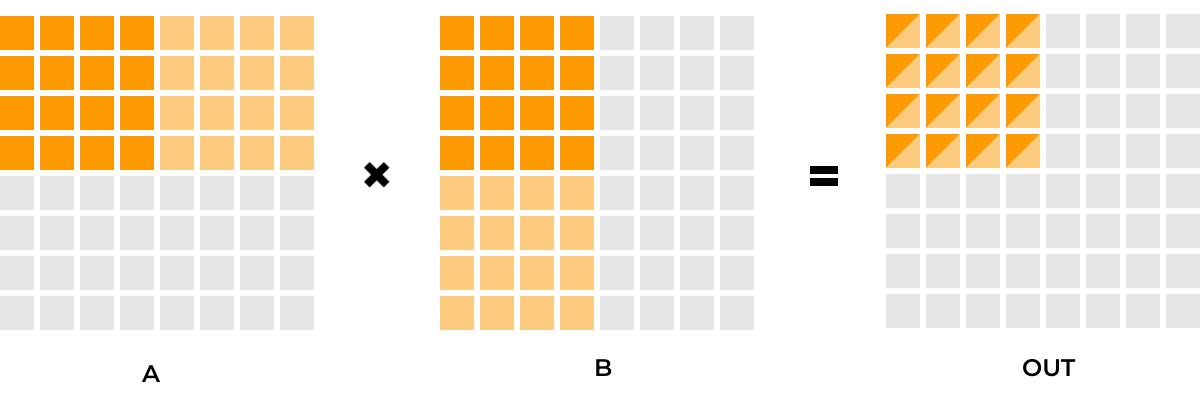

Теперь мы должны хранить только по 16 чисел для каждой из трех матриц, то есть мы влезли в ограничения. И кажется, что читаем мы даже столько же. Получается, бесплатный сыр? Не совсем: мы теперь должны записывать результат чаще, так как если раньше мы читали сразу все, чтобы получить этот блок, то теперь так не выйдет.

Отметим, что реализация такого подхода становится проще. Если положить размеры тайлов равными размеру блока выходной матрицы, то каждый тред читает ровно по одному числу из глобальной памяти и только его, пока обрабатывает tile. После чего, он вычисляет нужный кусок скалярного произведения, записывает результат в локальную переменную аккумулятор и переходит к обработке следующего tile.